In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
random.seed(42)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import math

# Import dataset

In [10]:
#Set path to folder containing train test file 
path = "D:\IIITD\DL\A1\Fashion MNIST\\"

In [12]:
X_train = pd.read_csv(path + "fashion-mnist_train.csv")
X_test = pd.read_csv(path + "fashion-mnist_test.csv")
Y_train = X_train.pop('label')
Y_test = X_test.pop('label')
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

# Data preprocessing

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [16]:
Y_train_enc = np.empty(shape=(Y_train.shape[0],10))
for idx,i in zip(range(len(Y_train)),Y_train):
    Y_train_enc[idx][i] = 1
Y_test_enc = np.empty(shape=(Y_test.shape[0],10))
for idx,i in zip(range(len(Y_test)),Y_test):
    Y_test_enc[idx][i] = 1


# Network Implementation

In [23]:
class network:
    def __init__(self, n_hidden, i_inputs, o_outputs, activation_function):
        self.n = len(n_hidden) # 512 512
        
        #List having structure of network
        self.n_layers = n_hidden
        self.i = i_inputs
        self.o = o_outputs
        self.choice = activation_function
        
        #add output layer to structure
        self.n_layers.append(self.o)
        #Weights of all layers stored as list
        self.weights = [] 
        #Bias of all layers stored as list
        self.bias = []
        
        #Weight initialization for hidden layer
        next_input = self.i
        for n_neurons in n_hidden:
            w = np.random.randn(n_neurons, next_input)*0.01
            self.weights.append(w)
            next_input = n_neurons
        #Weights for output layer
        self.weights.append(np.random.randn(self.o, next_input)*0.01)
        #Bias initialization for hidden layer
        for n_neurons in n_hidden:
            b = np.random.rand(n_neurons,1)*0.01
            self.bias.append(b)
        #Bias for output layer
        self.bias.append(np.random.rand(self.o,1)*0.01)
        
        
    def activation(self, X, choice = 0):
        #Sigmoid
        if choice == 0:  
            return 1.0 /(1.0 + np.exp(-X))
        #TanH
        elif choice == 1:
            return np.tanh(X)
        #ReLu
        elif choice == 2: 
            return np.maximum(X, 0) 
        #Softmax
        elif choice == 3:
            expX = np.exp(X) #,dtype=np.float128)  # WILL ONLY WORK ON COLAB. BUT NEEDED TO AVOID OVERFLOW
            return expX/np.sum(expX, axis = 0)
        
    
    def derivative(self, X, choice = 0):
        #Sigmoid
        if choice == 0: 
            d = self.activation(X, 0)
            return (d*(1-d))
        #TanH
        elif choice == 1:
            return (1 - np.power(np.tanh(X), 2))
        #ReLu
        elif choice == 2: 
            return np.array(X > 0, dtype = np.float32)
    
    
    def forward_prop(self, X):
        self.z = []
        self.a = []
        next_input = X.T
        #Traverse n hidden layers + 1 output layer
        for i in range(self.n+1):
            z = np.dot(self.weights[i], next_input) + self.bias[i]
            #SOFTMAX
            if i == self.n:
                a = self.activation(z,3)
            #Activation function of choice
            else:
                a = self.activation(z,self.choice)
            next_input = a
            self.z.append(z)
            self.a.append(a)
        return next_input
    
    def loss_function(self, op, Y):
        #Calculates cross entropy loss
        m = Y.shape[0]
        loss = -(1/m)*np.sum(Y.T*np.log(op)) 
        return loss
        
    def backward_prop(self, X, Y):
        n = X.shape[0]
        self.weight_gradients = []
        self.bias_gradients = []
        
        #Gradient Calculation for Output layer
        dz = self.a[-1] - Y.T
        dw = (1/n)*np.dot(dz, self.a[-2].T)
        db = (1/n)*np.sum(dz, axis = 1, keepdims = True)
        self.weight_gradients.append(dw)
        self.bias_gradients.append(db)
        #Gradients for Hidden layers
        for i in reversed(range(self.n)):
            dz = (1/n)*np.dot(self.weights[i+1].T, dz)*self.derivative(self.a[i], self.choice)
            if i == 0:
                dw = (1/n)*np.dot(dz, X)
            else:
                dw = (1/n)*np.dot(dz, self.z[i-1].T)
            db = (1/n)*np.sum(dz, axis = 1, keepdims = True)
            self.weight_gradients.append(dw)
            self.bias_gradients.append(db)
        self.weight_gradients.reverse()
        self.bias_gradients.reverse()
    
    #GRADIENT DESCENT
    def grad_desc(self, learning_rate):
        for i in range(self.n+1):
            self.weights[i] -= learning_rate * self.weight_gradients[i]
            self.bias[i] -= learning_rate * self.bias_gradients[i]
            
    #GRADIENT DESCENT WITH MOMENTUM
    def grad_desc_moment(self, learning_rate, momentum_weight):
        Vw = []
        Vb = []
        for i in range(self.n+1):
            Vw.append(np.zeros(self.weight_gradients[i].shape))
            Vb.append(np.zeros(self.bias_gradients[i].shape))
        
        for i in range(self.n+1):
            Vw[i] = momentum_weight * Vw[i] + (1 - momentum_weight) * self.weight_gradients[i]
            Vb[i] = momentum_weight * Vb[i] + (1 - momentum_weight) * self.bias_gradients[i]
            self.weights[i] -= learning_rate * Vw[i]
            self.bias[i] -= learning_rate * Vb[i]
            
    #NESTEROV ACCELERATED GRADIENT
    def NAG(self, learning_rate, momentum_weight, X, Y):
        w = []
        b = []
        for i in range(self.n+1):
            w.append(self.weights[i])
            b.append(self.bias[i])
            self.weights[i] = self.weights[i] - momentum_weight * self.Vw[i]
            self.bias[i] = self.bias[i] - momentum_weight * self.Vb[i]

        op = self.forward_prop(X)
        self.backward_prop(X, Y)

        for i in range(self.n+1):
            self.Vw[i] = momentum_weight * self.Vw[i] + learning_rate * self.weight_gradients[i]
            self.Vb[i] = momentum_weight * self.Vb[i] + learning_rate * self.bias_gradients[i]
            self.weights[i] = w[i] - self.Vw[i]
            self.bias[i] = b[i] - self.Vb[i]
            
    #ROOT MEAN SQUARE PROPOGATION
    def RMSProp(self, learning_rate, beta = 0.9):
        Sw = []
        Sb = []
        for i in range(self.n+1):
            Sw.append(np.zeros(self.weight_gradients[i].shape))
            Sb.append(np.zeros(self.bias_gradients[i].shape))

        for i in range(self.n+1):
            Sw[i] = beta * Sw[i] + (1 - beta) * (self.weight_gradients[i] ** 2)
            Sw[i] += 1e-8
            Sb[i] = beta * Sb[i] + (1 - beta) * (self.bias_gradients[i] ** 2)
            Sb[i] += 1e-8
            self.weights[i] -= learning_rate * (self.weight_gradients[i]/np.sqrt(Sw[i]))
            self.bias[i] -= learning_rate * (self.bias_gradients[i]/np.sqrt(Sb[i]))
    
    #ADAPTIVE GRADIENTS
    def Adagrad(self, learning_rate):
        Gw = []
        Gb = []
        for i in range(self.n+1):     
            Gw.append(np.zeros(self.weight_gradients[i].shape))
            Gb.append(np.zeros(self.bias_gradients[i].shape))

        for i in range(self.n+1):
            Gw[i] += (self.weight_gradients[i] ** 2)
            Gw[i] += 1e-8
            Gb[i] = (self.bias_gradients[i] ** 2)
            Gb[i] += 1e-8
            self.weights[i] -= learning_rate * (self.weight_gradients[i]/np.sqrt(Gw[i]))
            self.bias[i] -= learning_rate * (self.bias_gradients[i]/np.sqrt(Gb[i]))

    def Adam(self, learning_rate, beta1 = 0.9, beta2 = 0.999):
        Sw = []
        Sb = []
        Vw = []
        Vb = []
        for i in range(self.n+1):
            
            Sw.append(np.zeros(self.weight_gradients[i].shape))
            Sb.append(np.zeros(self.bias_gradients[i].shape))
            Vw.append(np.zeros(self.weight_gradients[i].shape))
            Vb.append(np.zeros(self.bias_gradients[i].shape))

        for i in range(self.n+1):
            Vw[i] = beta1 * Vw[i] + (1 - beta1) * self.weight_gradients[i]
            Vb[i] = beta1 * Vb[i] + (1 - beta1) * self.bias_gradients[i]

            Sw[i] = beta2 * Sw[i] + (1 - beta2) * (self.weight_gradients[i] ** 2)
            Sw[i] += 1e-8
            Sb[i] = beta2 * Sb[i] + (1 - beta2) * (self.bias_gradients[i] ** 2)
            Sb[i] += 1e-8
            self.weights[i] -= learning_rate * (Vw[i]/np.sqrt(Sw[i]))
            self.bias[i] -= learning_rate * (Vb[i]/np.sqrt(Sb[i]))
        
    def train(self, X, Y, learning_rate, n_epoch, batch_size, optimizer = 0, momentum_weight = 0.9):
        self.loss = {}
        for epoch in range(n_epoch):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                Y_batch = Y[i:i + batch_size]
                op = self.forward_prop(X_batch)
                self.backward_prop(X_batch, Y_batch)
                if optimizer == 0:#gradient_desc
                    self.grad_desc(learning_rate)
                
                elif optimizer == 1:#gradient_desc with momentum
                    self.grad_desc_moment(learning_rate, momentum_weight)

                elif optimizer == 2:#NAG
                    self.NAG(learning_rate, momentum_weight, X_batch, Y_batch)

                elif optimizer == 3:#RMSprop
                    self.RMSProp(learning_rate)

                elif optimizer == 4:#Adagrad
                    self.Adagrad(learning_rate)

                elif optimizer == 5:#Adam
                    self.Adam(learning_rate)

            op = self.forward_prop(X)    
            loss = self.loss_function(op, Y)
            self.loss[epoch] = loss
            print('epoch=%d, lrate=%.3f, loss=%.3f' % (epoch, learning_rate, loss))
            
    def predict(self, X):
        output = self.forward_prop(X)
        return np.argmax(output, 0)

# Constructing network

In [51]:
network_arch = [256]    #List representing neurons in each hidden layer eg. [128, 64]

# ACTIVATION FUNCTION CHOICES:
# 0: SIGMOID, 1: TANH, 2: RELU
activation_function = 2  

n_inputs = 784 #Features in dataset
o_outputs = 10 #Classes in target label

#Build network
net = network(network_arch, n_inputs, o_outputs, activation_function)

# Training network

In [52]:
batch_size = X_train.shape[0]  #Ideally in powers of 2
learning_rate, n_epoch = 0.1, 1000  #Learning rate depends on optimizer
# OPTIMIZER CHOICES:
# 0: GRADIENT DESCENT(DEFAULT)
# 1: GD WITH MOMENTUM
# 2: NAG
# 3: RMSPROP
# 4: ADAGRAD
# 5: ADAM
optimizer = 0
#Train network
net.train(X_train, Y_train_enc, learning_rate, n_epoch, batch_size, optimizer)

epoch=0, lrate=0.100, loss=2.302
epoch=1, lrate=0.100, loss=2.299
epoch=2, lrate=0.100, loss=2.295
epoch=3, lrate=0.100, loss=2.292
epoch=4, lrate=0.100, loss=2.289
epoch=5, lrate=0.100, loss=2.286
epoch=6, lrate=0.100, loss=2.283
epoch=7, lrate=0.100, loss=2.280
epoch=8, lrate=0.100, loss=2.277
epoch=9, lrate=0.100, loss=2.274
epoch=10, lrate=0.100, loss=2.271
epoch=11, lrate=0.100, loss=2.268
epoch=12, lrate=0.100, loss=2.265
epoch=13, lrate=0.100, loss=2.262
epoch=14, lrate=0.100, loss=2.259
epoch=15, lrate=0.100, loss=2.256
epoch=16, lrate=0.100, loss=2.254
epoch=17, lrate=0.100, loss=2.251
epoch=18, lrate=0.100, loss=2.248
epoch=19, lrate=0.100, loss=2.245
epoch=20, lrate=0.100, loss=2.243
epoch=21, lrate=0.100, loss=2.240
epoch=22, lrate=0.100, loss=2.237
epoch=23, lrate=0.100, loss=2.235
epoch=24, lrate=0.100, loss=2.232
epoch=25, lrate=0.100, loss=2.229
epoch=26, lrate=0.100, loss=2.227
epoch=27, lrate=0.100, loss=2.224
epoch=28, lrate=0.100, loss=2.222
epoch=29, lrate=0.100, l

epoch=238, lrate=0.100, loss=1.820
epoch=239, lrate=0.100, loss=1.819
epoch=240, lrate=0.100, loss=1.817
epoch=241, lrate=0.100, loss=1.816
epoch=242, lrate=0.100, loss=1.815
epoch=243, lrate=0.100, loss=1.813
epoch=244, lrate=0.100, loss=1.812
epoch=245, lrate=0.100, loss=1.810
epoch=246, lrate=0.100, loss=1.809
epoch=247, lrate=0.100, loss=1.807
epoch=248, lrate=0.100, loss=1.806
epoch=249, lrate=0.100, loss=1.804
epoch=250, lrate=0.100, loss=1.803
epoch=251, lrate=0.100, loss=1.802
epoch=252, lrate=0.100, loss=1.800
epoch=253, lrate=0.100, loss=1.799
epoch=254, lrate=0.100, loss=1.797
epoch=255, lrate=0.100, loss=1.796
epoch=256, lrate=0.100, loss=1.794
epoch=257, lrate=0.100, loss=1.793
epoch=258, lrate=0.100, loss=1.792
epoch=259, lrate=0.100, loss=1.790
epoch=260, lrate=0.100, loss=1.789
epoch=261, lrate=0.100, loss=1.787
epoch=262, lrate=0.100, loss=1.786
epoch=263, lrate=0.100, loss=1.785
epoch=264, lrate=0.100, loss=1.783
epoch=265, lrate=0.100, loss=1.782
epoch=266, lrate=0.1

epoch=473, lrate=0.100, loss=1.550
epoch=474, lrate=0.100, loss=1.549
epoch=475, lrate=0.100, loss=1.548
epoch=476, lrate=0.100, loss=1.547
epoch=477, lrate=0.100, loss=1.546
epoch=478, lrate=0.100, loss=1.545
epoch=479, lrate=0.100, loss=1.544
epoch=480, lrate=0.100, loss=1.544
epoch=481, lrate=0.100, loss=1.543
epoch=482, lrate=0.100, loss=1.542
epoch=483, lrate=0.100, loss=1.541
epoch=484, lrate=0.100, loss=1.540
epoch=485, lrate=0.100, loss=1.539
epoch=486, lrate=0.100, loss=1.538
epoch=487, lrate=0.100, loss=1.537
epoch=488, lrate=0.100, loss=1.536
epoch=489, lrate=0.100, loss=1.536
epoch=490, lrate=0.100, loss=1.535
epoch=491, lrate=0.100, loss=1.534
epoch=492, lrate=0.100, loss=1.533
epoch=493, lrate=0.100, loss=1.532
epoch=494, lrate=0.100, loss=1.531
epoch=495, lrate=0.100, loss=1.530
epoch=496, lrate=0.100, loss=1.530
epoch=497, lrate=0.100, loss=1.529
epoch=498, lrate=0.100, loss=1.528
epoch=499, lrate=0.100, loss=1.527
epoch=500, lrate=0.100, loss=1.526
epoch=501, lrate=0.1

epoch=708, lrate=0.100, loss=1.377
epoch=709, lrate=0.100, loss=1.376
epoch=710, lrate=0.100, loss=1.376
epoch=711, lrate=0.100, loss=1.375
epoch=712, lrate=0.100, loss=1.375
epoch=713, lrate=0.100, loss=1.374
epoch=714, lrate=0.100, loss=1.373
epoch=715, lrate=0.100, loss=1.373
epoch=716, lrate=0.100, loss=1.372
epoch=717, lrate=0.100, loss=1.372
epoch=718, lrate=0.100, loss=1.371
epoch=719, lrate=0.100, loss=1.370
epoch=720, lrate=0.100, loss=1.370
epoch=721, lrate=0.100, loss=1.369
epoch=722, lrate=0.100, loss=1.369
epoch=723, lrate=0.100, loss=1.368
epoch=724, lrate=0.100, loss=1.368
epoch=725, lrate=0.100, loss=1.367
epoch=726, lrate=0.100, loss=1.366
epoch=727, lrate=0.100, loss=1.366
epoch=728, lrate=0.100, loss=1.365
epoch=729, lrate=0.100, loss=1.365
epoch=730, lrate=0.100, loss=1.364
epoch=731, lrate=0.100, loss=1.363
epoch=732, lrate=0.100, loss=1.363
epoch=733, lrate=0.100, loss=1.362
epoch=734, lrate=0.100, loss=1.362
epoch=735, lrate=0.100, loss=1.361
epoch=736, lrate=0.1

epoch=943, lrate=0.100, loss=1.258
epoch=944, lrate=0.100, loss=1.258
epoch=945, lrate=0.100, loss=1.257
epoch=946, lrate=0.100, loss=1.257
epoch=947, lrate=0.100, loss=1.256
epoch=948, lrate=0.100, loss=1.256
epoch=949, lrate=0.100, loss=1.256
epoch=950, lrate=0.100, loss=1.255
epoch=951, lrate=0.100, loss=1.255
epoch=952, lrate=0.100, loss=1.254
epoch=953, lrate=0.100, loss=1.254
epoch=954, lrate=0.100, loss=1.254
epoch=955, lrate=0.100, loss=1.253
epoch=956, lrate=0.100, loss=1.253
epoch=957, lrate=0.100, loss=1.252
epoch=958, lrate=0.100, loss=1.252
epoch=959, lrate=0.100, loss=1.251
epoch=960, lrate=0.100, loss=1.251
epoch=961, lrate=0.100, loss=1.251
epoch=962, lrate=0.100, loss=1.250
epoch=963, lrate=0.100, loss=1.250
epoch=964, lrate=0.100, loss=1.249
epoch=965, lrate=0.100, loss=1.249
epoch=966, lrate=0.100, loss=1.249
epoch=967, lrate=0.100, loss=1.248
epoch=968, lrate=0.100, loss=1.248
epoch=969, lrate=0.100, loss=1.247
epoch=970, lrate=0.100, loss=1.247
epoch=971, lrate=0.1

# Store weights of network

In [53]:
title = "[256, 10], ReLu, lr=0.1, n_epoch = 1000"
np.save(title, net.weights)

C:\Users\Devansh\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


# Load weights

In [43]:
filename = '[256, 10], tanh, lr=0.0002 batch_size = 64, optimizer = Adam.npy'
net.weights = np.load(filename, allow_pickle=True)
net.weights = net.weights.tolist()

# Results 

In [54]:
y_pred_train = net.predict(X_train)
y_pred_test = net.predict(X_test)
print("Training accuracy: ",accuracy_score(Y_train, y_pred_train)*100)
print("Testing accuracy: ",accuracy_score(Y_test, y_pred_test)*100)

Training accuracy:  69.91833333333334
Testing accuracy:  70.02000000000001


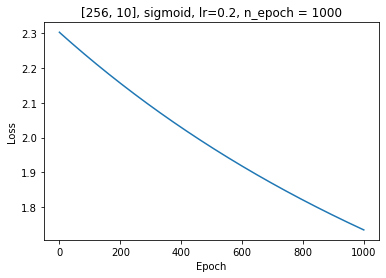

In [50]:
plt.plot(np.array(list(net.loss.keys())).astype(float),np.array(list(net.loss.values())).astype(float))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(title)
plt.show()